# Otus Machine Learning Course. Homework №2
### Воротников Владимир

---
### Резюме проделанной работы (со ссылками на разделы в документе)
[1. Базовый анализ данных](#1.-Базовый-анализ-данных)

Знакомство с данными. Замена существующих NaN-ов. Heatmap для матрицы корелляций

[2. Анализ отдельных переменных](#2.-Анализ-отдельных-переменных)

В разделе анализируется каждая переменная по отдельности. Кроме того, сделаны минимально необходимые модификации:
 - кодирование neighbourhood_group, room_type через dummies
 - выбраны параметры, которые нужно отнормировать после разбиения на train/test: 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'

[3. Получение базовой оценки качества](#3.-Получение-базовой-оценки-качества)

Разбиение на train-test. Нормализация. Построены модели линейной регрессии, получены показатели качества (R2, MAE, RMSE) как базовая метрика

[4. Улучшение и создание новых переменных](#4.-Улучшение-и-создание-новых-переменных)

Опробовано следующее:
 - кодирование neighbourhood через dummies: **небольшой положительный эффект**
 - замена аномалий в параметрах 'price', 'minimum_nights': **значительный положительный эффект**
 - перевод 'latitude', 'longitude' в параметр расстояния от центра Манхэттена: **небольшой положительный эффект**
 - удаление 'reviews_per_month', как имеющего корелляцию с 'number_of_reviews': **минимальное влияние**

[5. Подведение итогов](#5.-Подведение-итогов)

Удалось уменьшить RMSE с 222.2 (наивная оценка: всегда использовать среднее) и 204.6(для модели Lasso с минимальной модификацией переменных) до 82.5 после модификации данных. Наибольший эффект дало удаление аномалий

---

In [971]:
import itertools
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [972]:
data = pd.read_csv('data/AB_NYC_2019.csv')
data = data.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)

### 1. Базовый анализ данных

In [973]:
print("Data shape is {0}".format(data.shape))
display(data.head(3))

Data shape is (48895, 11)


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365


In [974]:
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [975]:
data.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [976]:
(data['number_of_reviews'] == 0).sum()

10052

In [977]:
data = data.fillna(0)

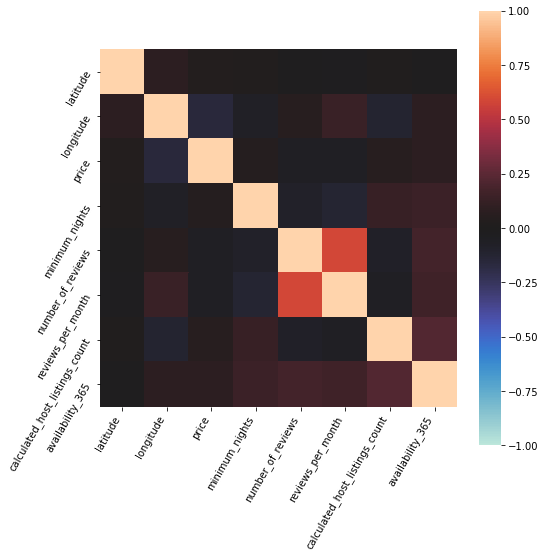

In [978]:
data_corr = data.corr() 
# Нарисуем heatmap для матрицы корреляций

fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(
    data_corr, 
    vmin=-1, vmax=1, center=0,
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment='right'
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=60,
)
ax.plot();

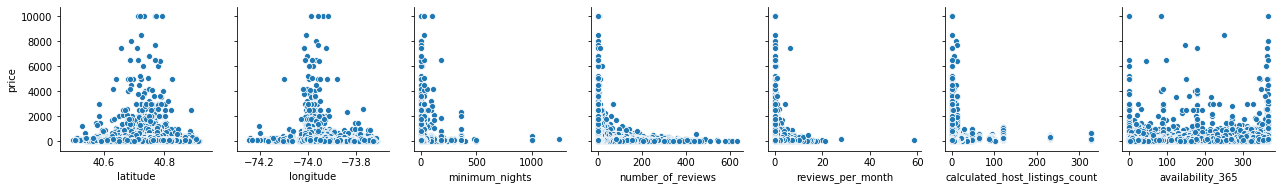

In [979]:
numeric_columns = ['latitude', 'longitude',
       'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365']
sns.pairplot(data=data, y_vars=['price'], x_vars=numeric_columns);

### 2. Анализ отдельных переменных

In [980]:
TARGET = 'price'
TO_DROP = []
TO_SCALE = []

### - neighbourhood_group

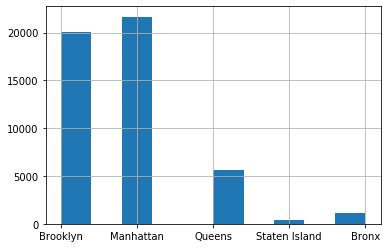

In [981]:
data.neighbourhood_group.hist();

In [982]:
nb_group = pd.get_dummies(data['neighbourhood_group'], prefix='nb_group')
data = pd.concat([data, nb_group], axis=1)
TO_DROP.append('neighbourhood_group')

### - neighbourhood

In [983]:
print(data['neighbourhood'].value_counts())
data['neighbourhood'].value_counts().describe()

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Richmondtown             1
Willowbrook              1
Rossville                1
Woodrow                  1
Fort Wadsworth           1
Name: neighbourhood, Length: 221, dtype: int64


count     221.000000
mean      221.244344
std       536.160961
min         1.000000
25%        10.000000
50%        32.000000
75%       154.000000
max      3920.000000
Name: neighbourhood, dtype: float64

In [984]:
TO_DROP.append('neighbourhood')

### - latitude, longitude

In [985]:
print(data['latitude'].min(), data['latitude'].max())
print(data['longitude'].min(), data['longitude'].max())

40.499790000000004 40.913059999999994
-74.24441999999999 -73.71299


In [986]:
data.groupby(['neighbourhood_group']).price.mean()

neighbourhood_group
Bronx             87.496792
Brooklyn         124.383207
Manhattan        196.875814
Queens            99.517649
Staten Island    114.812332
Name: price, dtype: float64

### - room_type

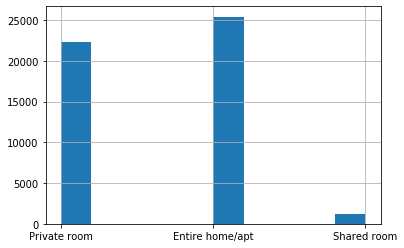

In [987]:
data.room_type.hist();

In [988]:
room_type = pd.get_dummies(data['room_type'], prefix='room_type')
data = pd.concat([data, room_type], axis=1)
TO_DROP.append('room_type')

### - price

In [989]:
data.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [990]:
len(data[data.price==0])

11

In [991]:
data.price = data.price.replace(0, data.price.mean())

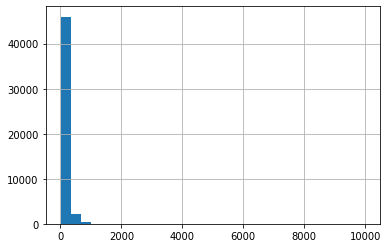

In [992]:
data['price'].hist(bins=30);

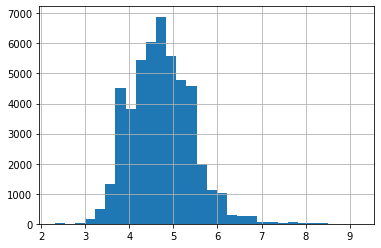

In [993]:
np.log(data['price']).hist(bins=30);

In [994]:
len(data[data.price>data.price.mean()+3*data.price.std()])

388

### - minimum_nights

In [995]:
data.minimum_nights.describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [996]:
len(data[data.minimum_nights>data.minimum_nights.mean()+3*data.minimum_nights.std()])

327

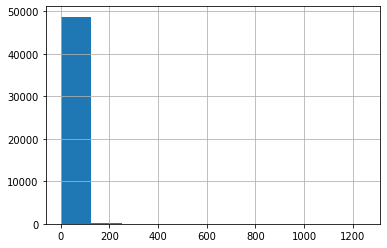

In [997]:
data.minimum_nights.hist();

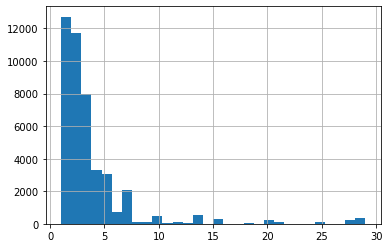

In [998]:
data[data.minimum_nights < 30].minimum_nights.hist(bins=30);

In [999]:
TO_SCALE.append('minimum_nights')

### - number_of_reviews, reviews_per_month

In [1000]:
data.number_of_reviews.corr(data.reviews_per_month)

0.5894072970835162

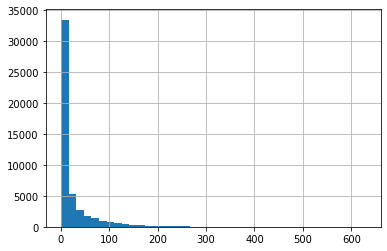

In [1001]:
data.number_of_reviews.hist(bins=40);

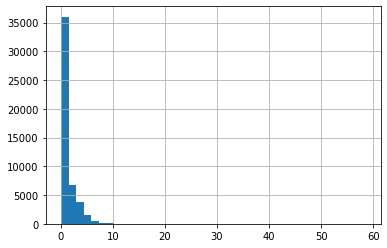

In [1002]:
data.reviews_per_month.hist(bins=40);

In [1003]:
TO_SCALE.append('number_of_reviews')
TO_SCALE.append('reviews_per_month')

### - calculated_host_listings_count

In [1004]:
data.calculated_host_listings_count.describe([0.9, 0.95])

count    48895.000000
mean         7.143982
std         32.952519
min          1.000000
50%          1.000000
90%          5.000000
95%         15.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

In [1005]:
TO_SCALE.append('calculated_host_listings_count')

### - availability_365

In [1006]:
data.availability_365.value_counts()

0      17533
365     1295
364      491
1        408
89       361
       ...  
195       26
196       24
183       24
181       23
202       20
Name: availability_365, Length: 366, dtype: int64

In [1007]:
TO_SCALE.append('availability_365')

In [1008]:
data_basic = data.copy(deep=True)

### 3. Получение базовой оценки качества

In [1009]:
data = data_basic.copy(deep=True)
data.drop(TO_DROP, axis=1, inplace=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop([TARGET], axis=1), data[TARGET], test_size=0.3, random_state=37)

X_train.shape, X_test.shape

((34226, 15), (14669, 15))

In [1010]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()

train_scaled_data = scaler.fit_transform(X_train[TO_SCALE])
test_scaled_data = scaler.transform(X_test[TO_SCALE])

In [1011]:
X_train[TO_SCALE] = train_scaled_data
X_test[TO_SCALE] = test_scaled_data

In [1012]:
y_mean = np.median(y_train)
y_pred_naive = np.ones(len(y_test)) * y_mean
y_pred_naive[:2]

array([106., 106.])

In [1013]:
from sklearn import metrics  # подгружаем метрики
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})

In [1014]:
measured_metrics["naive"] = dataframe_metrics(y_test, y_pred_naive)
measured_metrics

,error_type,naive
0,MAE,82.493383
1,RMSE,222.162066
2,R2,-0.043562
3,MAPE,56.582059


In [1015]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5)

lasso_cv.fit(X_train, y_train)
print('Лучшее значение параметра:', lasso_cv.alpha_)

y_pred_lasso = lasso_cv.predict(X_test)

measured_metrics["lasso_cv"] = dataframe_metrics(y_test, y_pred_lasso)
measured_metrics

Лучшее значение параметра: 0.031120412400887594


,error_type,naive,lasso_cv
0,MAE,82.493383,72.711508
1,RMSE,222.162066,204.635879
2,R2,-0.043562,0.114595
3,MAPE,56.582059,55.147385


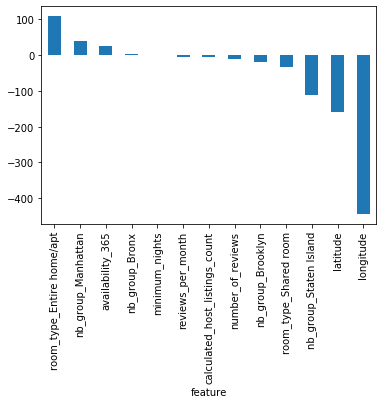

In [1016]:
featureImportance = pd.DataFrame({"feature": X_train.columns[lasso_cv.coef_!=0], 
                                  "importance": lasso_cv.coef_[lasso_cv.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar();

In [1017]:
from sklearn.linear_model import ElasticNetCV

elastic_cv = ElasticNetCV(cv=5)

elastic_cv.fit(X_train, y_train)

y_pred_elastic = elastic_cv.predict(X_test)

measured_metrics["elastic_cv"] = dataframe_metrics(y_test, y_pred_elastic)
measured_metrics

,error_type,naive,lasso_cv,elastic_cv
0,MAE,82.493383,72.711508,72.772371
1,RMSE,222.162066,204.635879,205.603103
2,R2,-0.043562,0.114595,0.106205
3,MAPE,56.582059,55.147385,56.626541


In [1018]:
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(cv=5)

ridge_cv.fit(X_train, y_train)

y_pred_ridge = ridge_cv.predict(X_test)

measured_metrics["ridge_cv"] = dataframe_metrics(y_test, y_pred_ridge)
measured_metrics

,error_type,naive,lasso_cv,elastic_cv,ridge_cv
0,MAE,82.493383,72.711508,72.772371,72.770291
1,RMSE,222.162066,204.635879,205.603103,204.607121
2,R2,-0.043562,0.114595,0.106205,0.114844
3,MAPE,56.582059,55.147385,56.626541,55.193479


### 4. Улучшение и создание новых переменных

In [1019]:
data = data_basic.copy(deep=True)
TO_DROP = ['neighbourhood_group', 'neighbourhood', 'room_type']
TO_SCALE = ['minimum_nights', 'calculated_host_listings_count', 'availability_365']

metrics_table = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
metrics_table.set_index("error_type")
metrics_table["naive"] = measured_metrics["naive"] 
metrics_table["no_mods"] = measured_metrics["lasso_cv"]

### 4.1 neighbourhood в dummies

In [1020]:
nb = pd.get_dummies(data['neighbourhood'], prefix='nb')
data = pd.concat([data, nb], axis=1)

### 4.2 Замена аномалий в параметрах price и minimum_nights

In [1021]:
data.drop(data[data.minimum_nights>data.minimum_nights.mean()+3*data.minimum_nights.std()].index, axis=0, inplace=True)
data.drop(data[data.price>800].index, axis=0, inplace=True)

### 4.3 Расстояние до центра вместо координат

In [1022]:
manhattan_lat = data[data['neighbourhood_group']=='Manhattan'].latitude.mean()
manhattan_lon = data[data['neighbourhood_group']=='Manhattan'].longitude.mean()

data['distance_from_center'] = np.sqrt(np.square(data['latitude']-manhattan_lat) + np.square(data['longitude']-manhattan_lon))
data.groupby(['neighbourhood_group']).distance_from_center.mean()

neighbourhood_group
Bronx            0.124390
Brooklyn         0.087380
Manhattan        0.039065
Queens           0.110791
Staten Island    0.204486
Name: distance_from_center, dtype: float64

In [1023]:
TO_DROP.append('latitude')
TO_DROP.append('longitude')
TO_SCALE.append('distance_from_center')

### 4.4 Убираем параметр review_per_month

In [1024]:
TO_DROP.append('reviews_per_month')

### 4.N Оценка проведенных изменений

In [1025]:
data.drop(TO_DROP, axis=1, inplace=True)  

X_train, X_test, y_train, y_test = train_test_split(data.drop([TARGET], axis=1), data[TARGET], test_size=0.3, random_state=37)

scaler = StandardScaler()

X_train[TO_SCALE] = scaler.fit_transform(X_train[TO_SCALE])
X_test[TO_SCALE] = scaler.transform(X_test[TO_SCALE])

In [1026]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33715, 234), (14450, 234), (33715,), (14450,))

In [1027]:
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train, y_train)
y_pred_lasso = lasso_cv.predict(X_test)

metrics_table["after_modifications"] = dataframe_metrics(y_test, y_pred_lasso) 

In [1028]:
metrics_table

,error_type,naive,no_mods,after_modifications
0,MAE,82.493383,72.711508,51.060394
1,RMSE,222.162066,204.635879,82.519062
2,R2,-0.043562,0.114595,0.386803
3,MAPE,56.582059,55.147385,42.380066


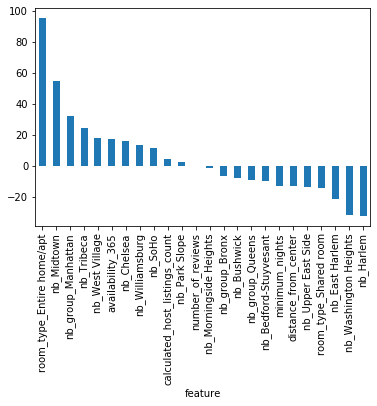

In [1029]:
featureImportance = pd.DataFrame({"feature": X_train.columns[lasso_cv.coef_!=0], 
                                  "importance": lasso_cv.coef_[lasso_cv.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar();

### 5. Подведение итогов

Удалось уменьшить RMSE с 222.2 (наивная оценка: всегда использовать среднее) и 204.6(для модели Lasso с минимальной модификацией переменных) до 82.5 после модификации данных. Наибольший эффект дало удаление аномалий

Наибольшее влияние на цену оказывет тип аппартаментов и район, в котором они находятся.